__Goal__: Test inversion

    After simulate a source galaxy and deflect it, it's time to test the inversion!
    
We do that using two different approaches:
    1. Using the MGE decomposition, as we do in the simulation
    2. Using the pseudo ellpitical NFW analytical model.

In [1]:
import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_4/Simulation_Data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)        #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)             #DM component

### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [3]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 4.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5
ml     = 7.00                                                          #mass to light ratio
phi_shear = 88                                                         #Inclination of external shear [deg]
mag_shear = 0.02                                                       #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

### Reading Data

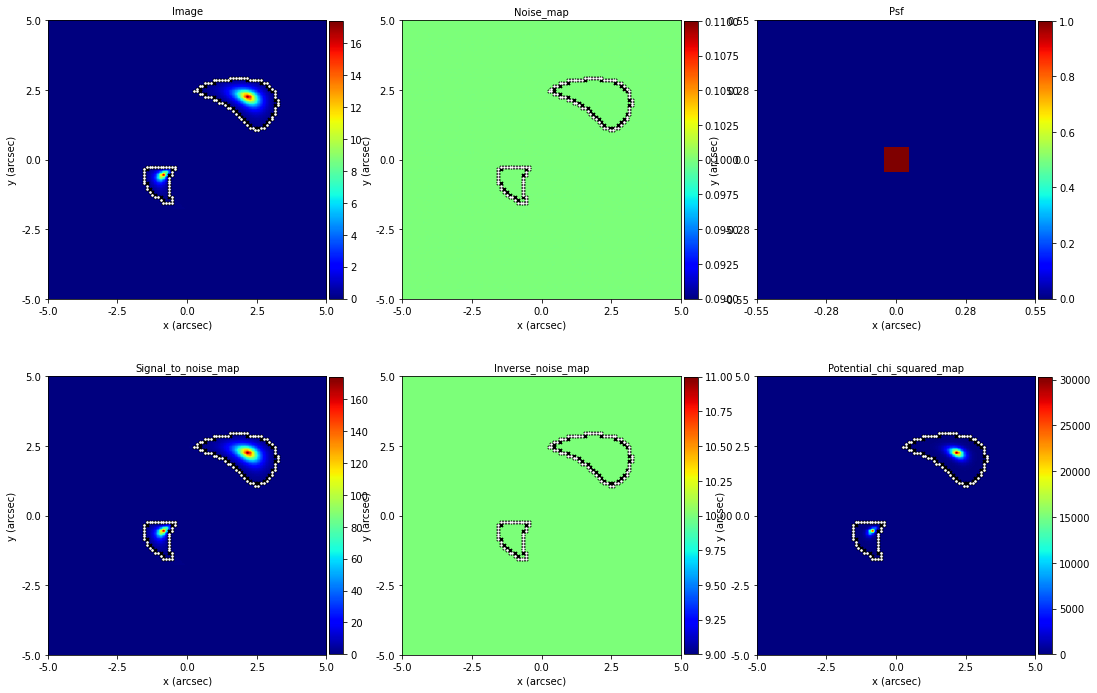

In [4]:
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/arcs_simulation.fits",
        noise_map_path=f"{data_folder}/noise_simulation.fits",
        psf_path=f"{data_folder}/psf_simulation.fits",
        pixel_scales=0.1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/new_mask.fits", hdu=1, 
                                    pixel_scales=imaging.pixel_scales)#You should check Mask_Maker folder before continue

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)     #Masked image


aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True),                         #Plot
)

In [5]:
masked_image.grid.shape

(476, 2)

## Starting model only MGE
Here we define the lens mass profile. This frist model uses the MGE eNFW decompostion.

In [6]:
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()


#Components
mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm =kappa_ * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [7]:
#Now we set the tracer to the source galaxy

start = clock()

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_s)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_image.grid)[1]

print("Elapsed time", clock() - start)

Elapsed time 4.121420699999362


We'll use the rectangular _Pixelization_ and _Mapper_ to perform the inversion.

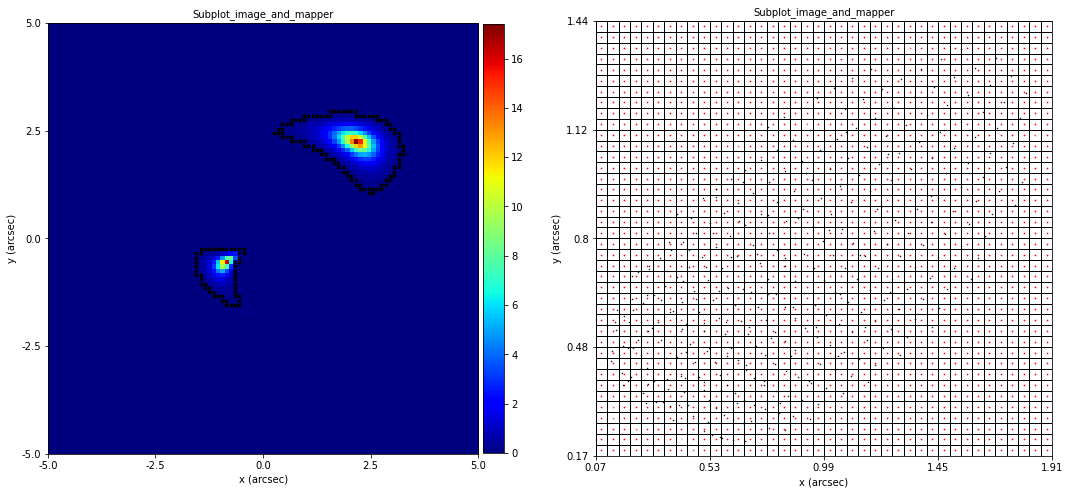

In [8]:
rectangular = al.pix.Rectangular(shape=(40, 40))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

And now, finally, we're going to use our _Mapper_ to invert the image using an _Inversion_.

In [9]:
start = clock()
inversion = al.Inversion(
    masked_dataset=masked_image,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=1.0),
)
print("Elapsed time", clock() - start)

Elapsed time 0.5833276699995622


Our _Inversion_ has a reconstructed image and _Pixeilzation_, whcih we can plot using an _Inversion_ plotter

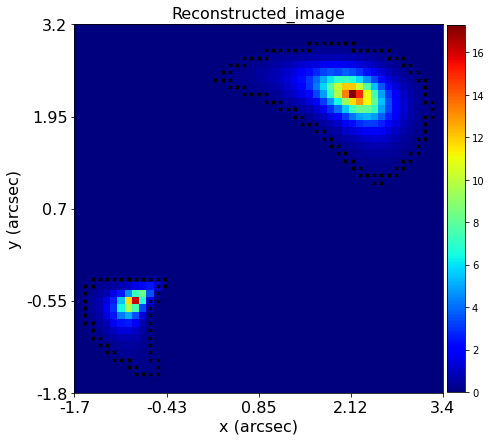

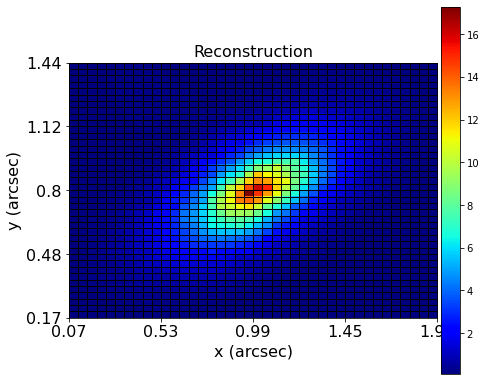

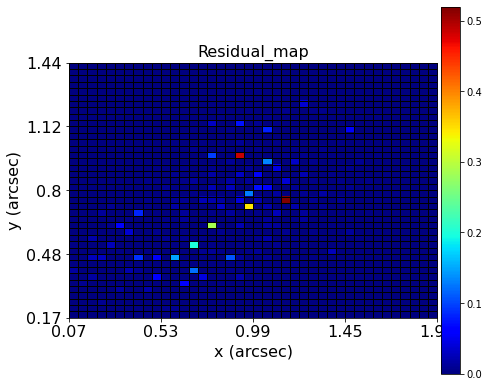

In [10]:
aplt.Inversion.reconstructed_image(inversion=inversion, include=aplt.Include(mask=True))

aplt.Inversion.reconstruction(
    inversion=inversion, include=aplt.Include(inversion_pixelization_grid=False, inversion_border=False)
)

aplt.Inversion.residual_map(inversion, include=aplt.Include(inversion_pixelization_grid=False,
                                                            inversion_border=False))

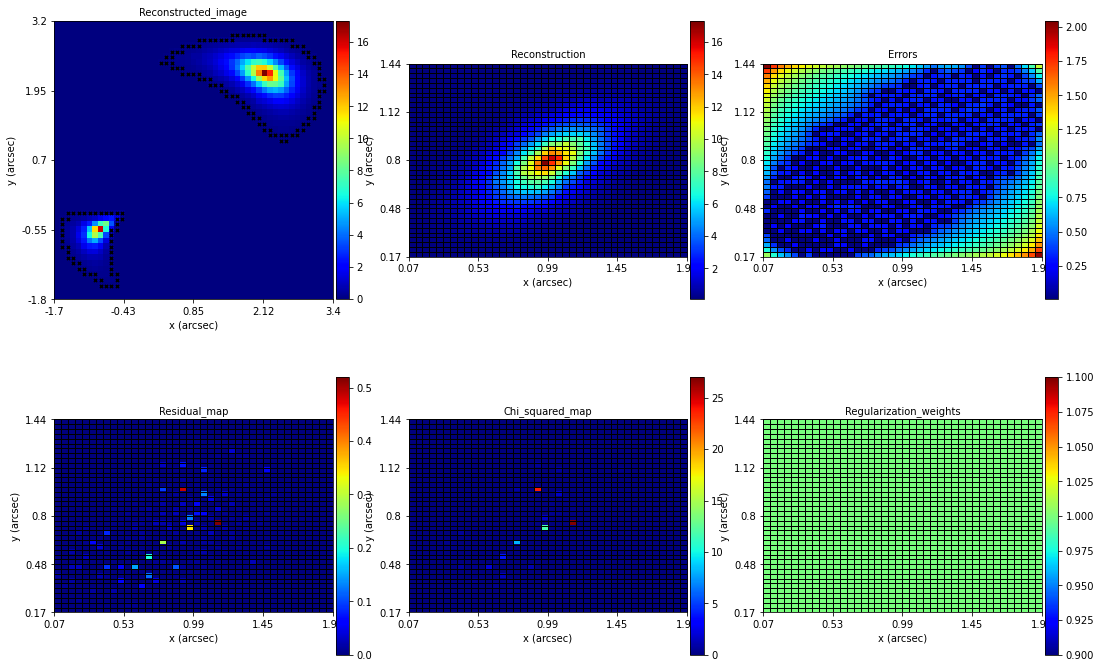

In [11]:
output=aplt.Output(path=data_folder,filename="Rectangular_Inversion_OnlyMGE", format="png")

plotter = aplt.SubPlotter(
    figure=aplt.Figure(figsize=(15, 15)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),output=output
)
#Save
aplt.Inversion.subplot_inversion(inversion,include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False), sub_plotter=plotter)

#Plot
aplt.Inversion.subplot_inversion(inversion, include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False))

## Inversion with Fit Tracer

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


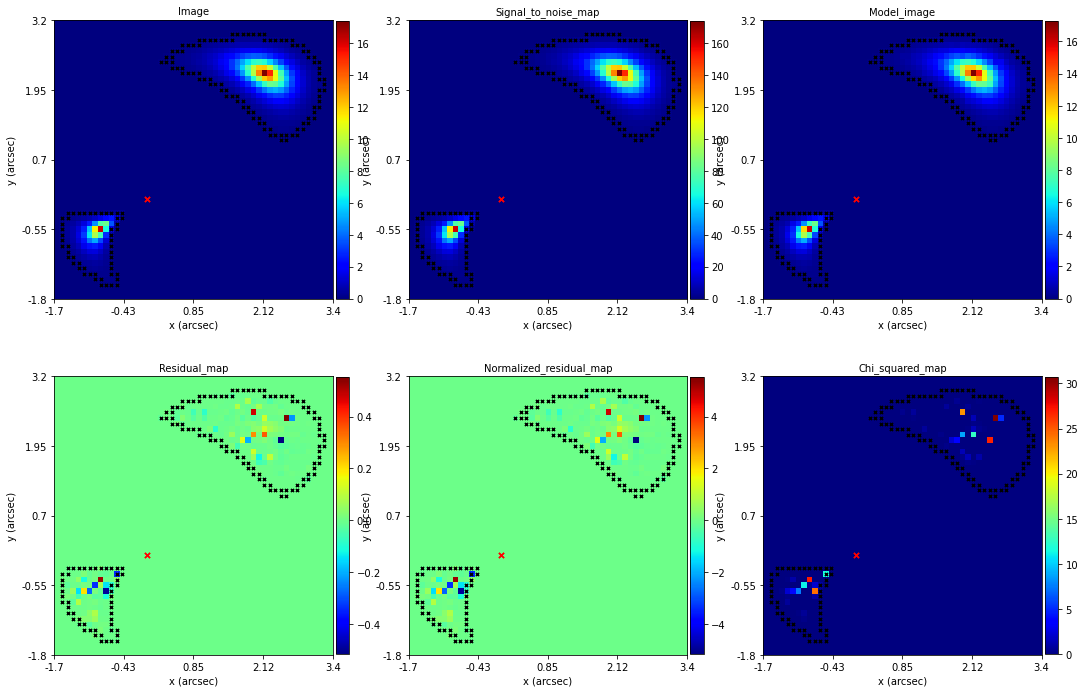

Log Likelihood with Regularization: 169.12873738428277


In [14]:
source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))
print("Log Likelihood with Regularization:", fit.log_likelihood_with_regularization)

## Starting model with eNFW

In [33]:
#MGE mass profile

#Initializing
 #Elliptical components in Pyautolens units
ell_comps = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0) #Elliptical components in Pyautolens units
eNFW      = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s) #pseudo elliptical NFW

mass_profile2 = al.mp.MGE()                            #MGE mass model
mass_profile2.Analytic_Model(analytic_profile=eNFW)   #Include the analytical pENFW

#Components
mass_profile2.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=7.7,
                       mbh=1e11) #DON'T INCLUDE THE MGE PARAMETRIZATION OF DM

#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy2 = al.Galaxy(
    redshift=z_l,
    mass=mass_profile2,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [34]:
#Now we set the tracer to the source galaxy

start = clock()

tracer2 = al.Tracer.from_galaxies(galaxies=[lens_galaxy2, al.Galaxy(redshift=z_s)])
source_plane_grid2 = tracer2.traced_grids_of_planes_from_grid(grid=masked_image.grid)[1]

print("Elapsed time", clock() - start)

Elapsed time 0.5594335959995078


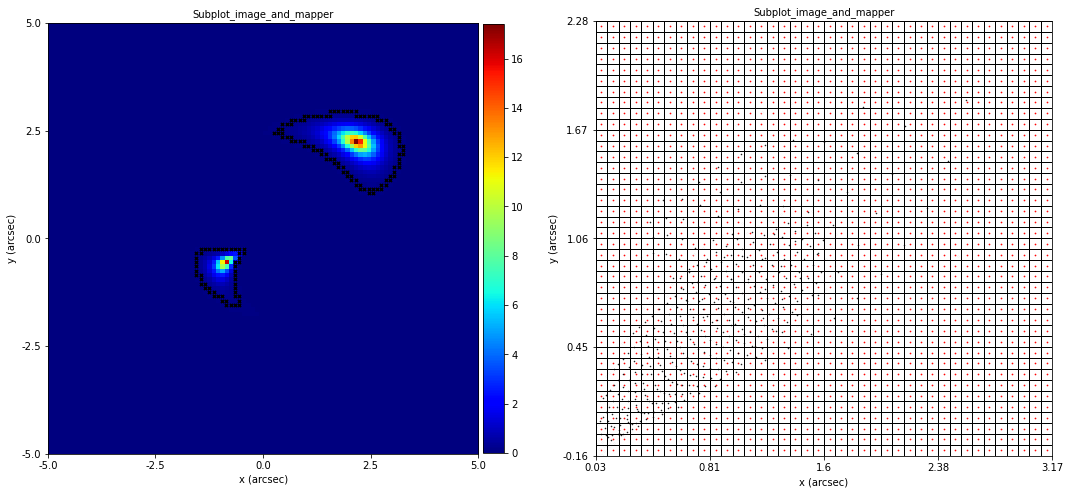

In [35]:
rectangular2 = al.pix.Rectangular(shape=(40, 40))

mapper2 = rectangular2.mapper_from_grid_and_sparse_grid(grid=source_plane_grid2)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper2,
    include=aplt.Include(mask=True, inversion_grid=True),
)

In [25]:
start = clock()
inversion2 = al.Inversion(
    masked_dataset=masked_image,
    mapper=mapper2,
    regularization=al.reg.Constant(coefficient=1.0),
)
print("Elapsed time", clock() - start)

Elapsed time 0.10617612700116297


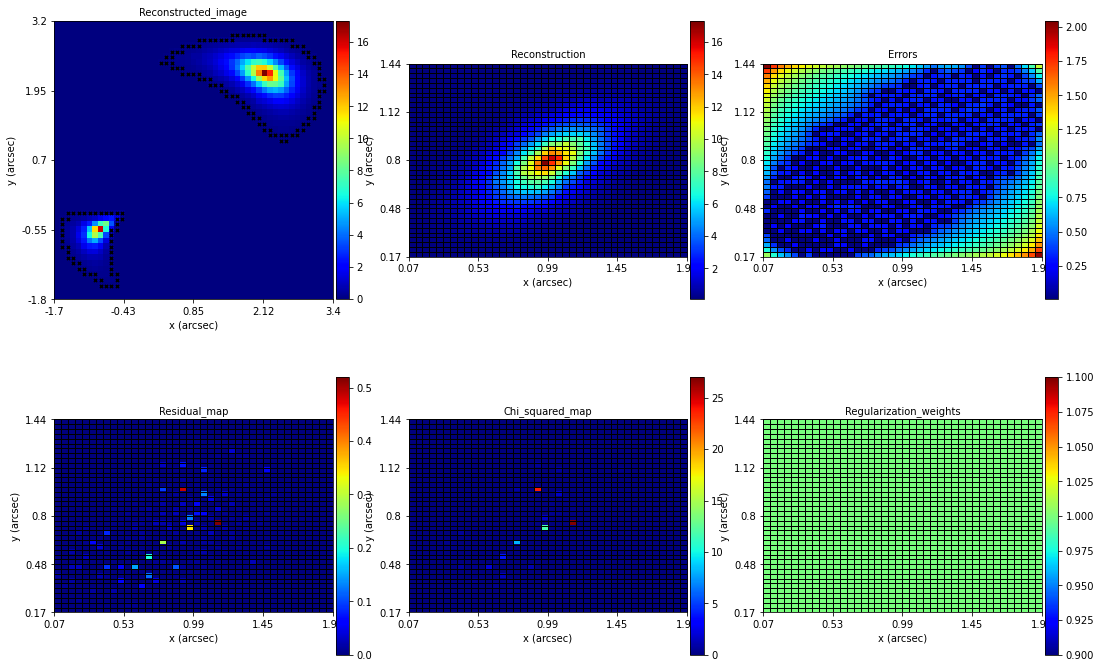

In [19]:
output=aplt.Output(path=data_folder,filename="Rectangular_Inversion_Analytical_eNFW", format="png")

plotter = aplt.SubPlotter(
    figure=aplt.Figure(figsize=(15, 15)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),output=output
)
#Save
aplt.Inversion.subplot_inversion(inversion2,include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False), sub_plotter=plotter)

#Plot
aplt.Inversion.subplot_inversion(inversion2, include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False))

## Inversion Using Fit Tracer

In [70]:
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear
ell_comps = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0) #Elliptical components in Pyautolens units
eNFW      = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s) #pseudo elliptical NFW

mass_profile2 = al.mp.MGE()                            #MGE mass model
mass_profile2.Analytic_Model(analytic_profile=eNFW)   #Include the analytical pENFW

#Components
mass_profile2.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh) #DON'T INCLUDE THE MGE PARAMETRIZATION OF DM

#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy2 = al.Galaxy(
    redshift=z_l,
    mass=mass_profile2,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [71]:
source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy2, source_galaxy])

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


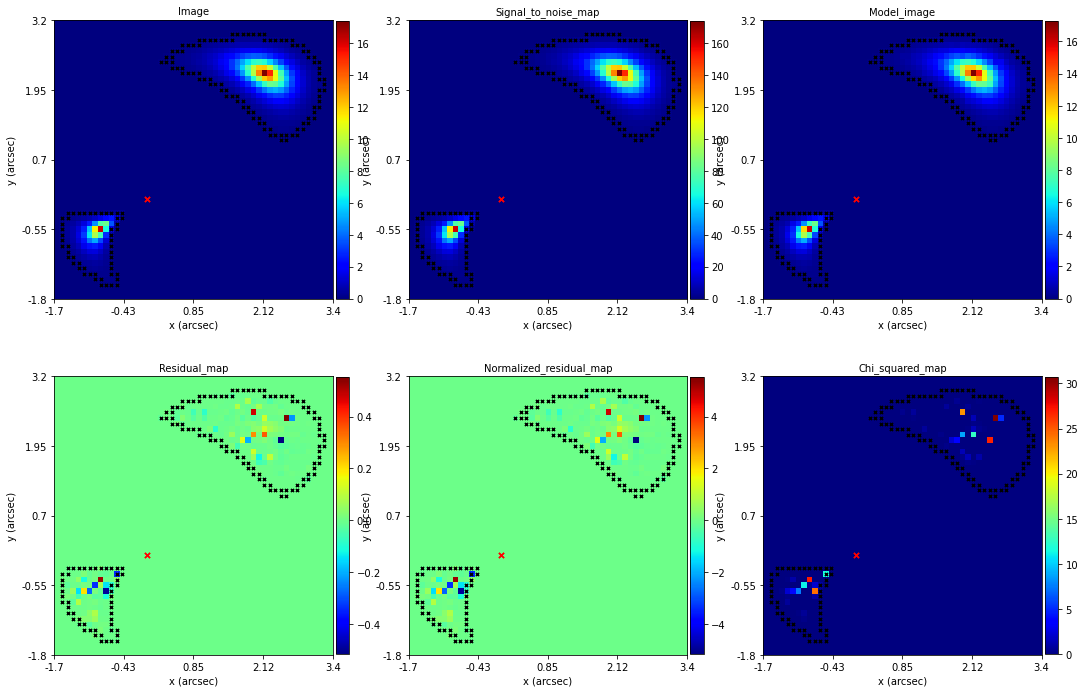

Log Likelihood with Regularization: 169.12873738428277


In [72]:
fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))
print("Log Likelihood with Regularization:", fit.log_likelihood_with_regularization)